# AMSC698K Homework 9
##### Elijah Kin & Noorain Noorani

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp

### Problem A
It is comparatively easy to set up the QAOA circuits for MaxCut problems. Without using "black-box" QAOA implementations (classes and methods) create quantum circuits to perform a max.cut of a weighted undirected graph with 6 vertices using QISkit, Cirq, or Pennylane.

1. Compare the results (frequency plots) for 2, 4, and 6 layers.

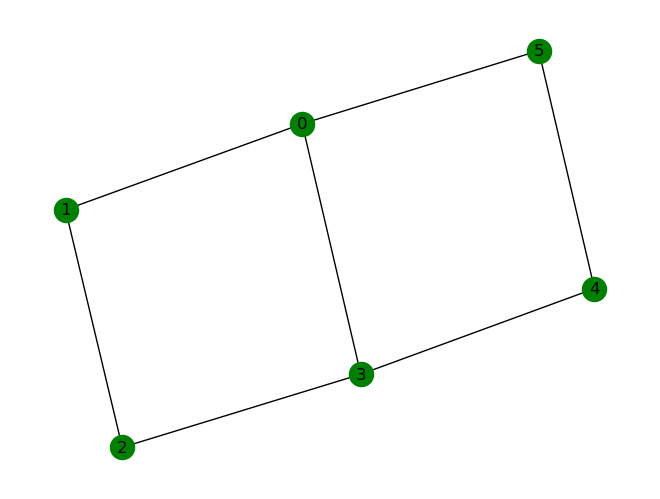

In [2]:
n_wires = 6
edges = [(0, 1), (0, 3), (1, 2), (2, 3), (3, 4), (4,5), (5,0)]

gr = nx.Graph(edges)
nx.draw(gr, with_labels=True, node_color="green")
plt.show()

In [3]:
# unitary operator U_m (mixer) with parameter beta
def U_m(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

# unitary operator U_c (cost) with parameter gamma
def U_c(gamma, edges):
    for edge in edges:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

In [4]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=1)

@qml.qnode(dev)
def circuit(gammas, betas, edge = None, n_layers=1):
    # apply Hadamards to get the n-qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # create instances of unitary operators
    for i in range(n_layers):
        U_c(gammas[i], edges)
        U_m(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [19]:
def qaoa_maxcut(n_layers=1, max_iter = 150):
    costs = []
    
    print("\nQAOA with {:d} layers".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * pnp.random.rand(2, n_layers, requires_grad=True)
    print("Initial parameters:\n{}".format(init_params))

    # minimize the negative of the objective function
    # 'circuit' returns only the contribution for a single edge (PauliZ(a)@PauliZ(b)),
    #   so we loop over all edges
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in edges:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works quite well
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    for i in range(1,max_iter+1):
        params = opt.step(objective, params)
        cost = objective(params)
        if i % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i, cost))
        costs.append(cost)

    def bitstring_to_int(bit_string_sample):
      bit_string = "".join(str(bs) for bs in bit_string_sample)
      return int(bit_string, base=2)

    # sample measured bitstrings 100 times ('lightning.qubit' allows for 1 shot at a time)
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {0:0{1}b}".format(most_freq_bit_string,n_wires))

    return -objective(params), bit_strings, costs

In [6]:
nlayers = [2, 4, 6]

# and keep the bitstring sample lists 
nlayer_bitstrings = {}
nlayer_costs = {}

for jj in nlayers:
    _, bitstring, costs = qaoa_maxcut(n_layers=jj)
    nlayer_bitstrings[jj] = bitstring
    nlayer_costs[jj] = costs


QAOA with 2 layers
Initial parameters:
[[0.00673466 0.00520565]
 [0.00468518 0.00057832]]
Objective after step     5: -5.0000000
Objective after step    10: -6.0000000
Objective after step    15: -5.0000000
Objective after step    20: -6.0000000
Objective after step    25: -6.0000000
Objective after step    30: -4.0000000
Objective after step    35: -4.0000000
Objective after step    40: -5.0000000
Objective after step    45: -4.0000000
Objective after step    50: -5.0000000
Objective after step    55: -6.0000000
Objective after step    60: -4.0000000
Objective after step    65: -5.0000000
Objective after step    70: -4.0000000
Objective after step    75: -7.0000000
Objective after step    80: -3.0000000
Objective after step    85: -5.0000000
Objective after step    90: -6.0000000
Objective after step    95: -4.0000000
Objective after step   100: -6.0000000
Objective after step   105: -6.0000000
Objective after step   110: -5.0000000
Objective after step   115: -5.0000000
Objective af

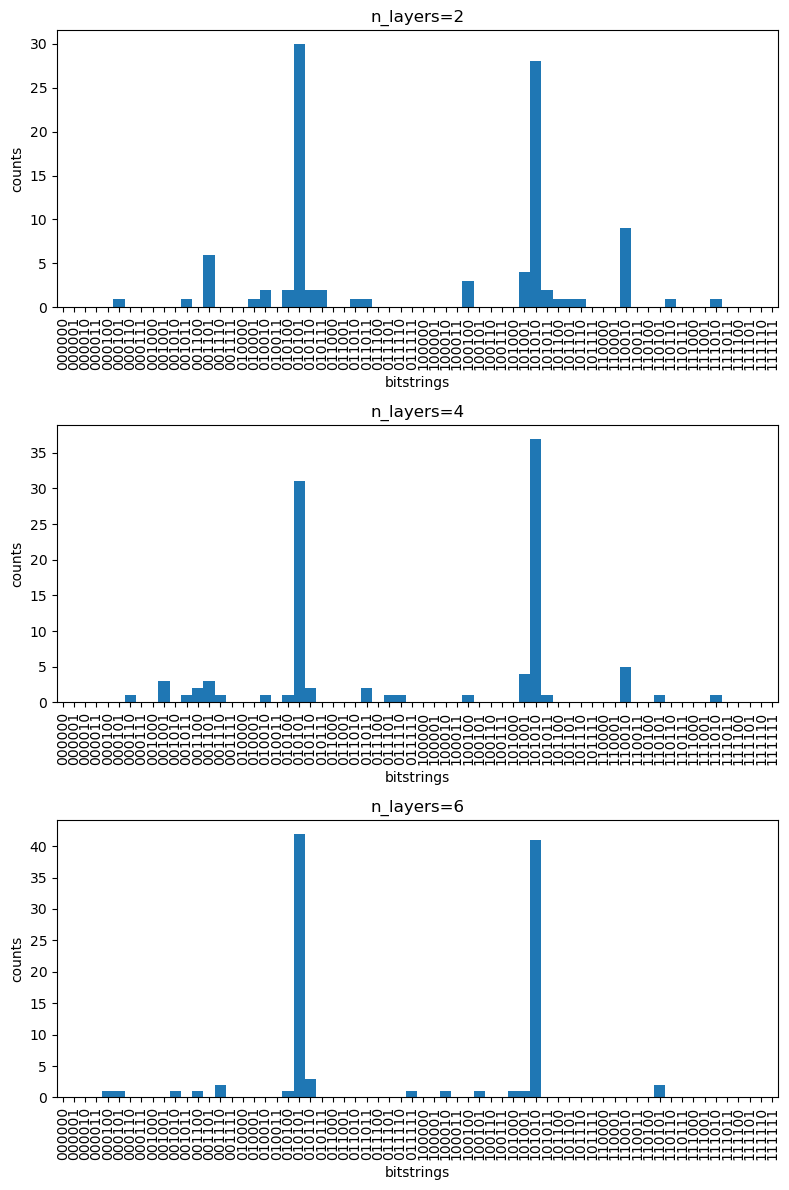

In [7]:
xticks = range(0, 2**n_wires)
xtick_labels = list(map(lambda x: format(x, "0{}b".format(n_wires)), xticks))
bins = np.arange(0, len(xticks)+1) - 0.5

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for jj in range(len(nlayers)):
    # key = nlayers[jj]
    plt.subplot(3, 1, jj + 1)
    plt.subplots_adjust(hspace=0.4)
    plt.title(f"n_layers={nlayers[jj]}")
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist(nlayer_bitstrings[nlayers[jj]], bins=bins)
    plt.margins(x=0)
plt.tight_layout()
plt.show()

2. Perform the optimization over 150 iterations for all three circuits (2-, 4-, 6-layers QAOA), compare the change of parameters and find the optimal number of iterations where the cost function is close to its minimum and the parameters don't change significantly.

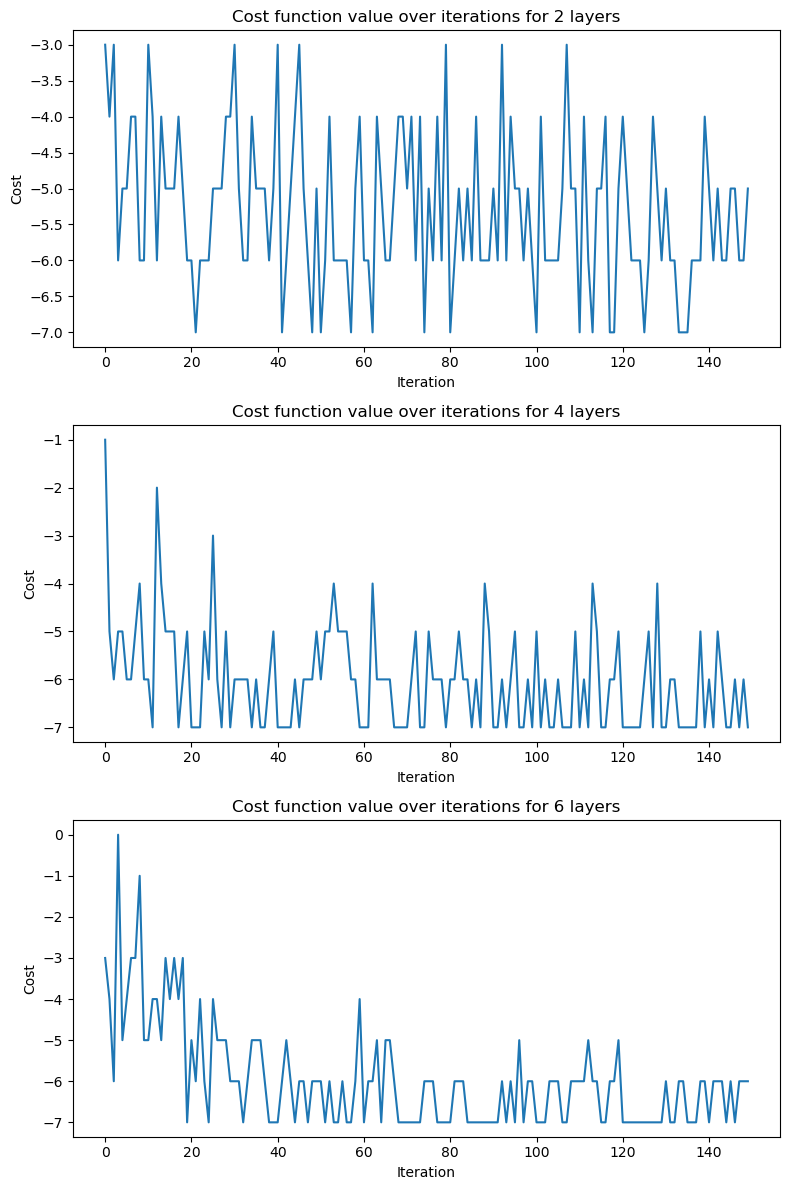

In [17]:
# Plot cost over iteration and solutions
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for jj in range(len(nlayers)):
    plt.subplot(3, 1, jj + 1)
    plt.plot(nlayer_costs[nlayers[jj]])
    plt.title(f"Cost function value over iterations for {nlayers[jj]} layers")
    plt.ylabel("Cost")
    plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

3. Perform the optimization of the 6-layer circuit for a maximum of 80 iterations on the IonQ simulator with "aria-1" noise-model or on the IonQ QPU Aria-1 (remember to set the optional argument: error_mitigation={"debias":False} ).

In [20]:
# TODO
device = qml.device("ionq.qpu", backend="qpu.aria-1", error_mitigation={"debias":False}, 
                                                                    wires=n_wires, shots=1)

@qml.qnode(device)
def circuit(gammas, betas, edge = None, n_layers=1):
    # apply Hadamards to get the n-qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # create instances of unitary operators
    for i in range(n_layers):
        U_c(gammas[i], edges)
        U_m(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [22]:
qml.default_config.path

'config.toml'

In [21]:
_, bitstring_ionq, costs_ionq = qaoa_maxcut(n_layers=6, max_iter=80)


QAOA with 6 layers
Initial parameters:
[[0.00182777 0.0077782  0.00721379 0.00010315 0.00810332 0.00344134]
 [0.00070239 0.00740364 0.00722917 0.00555152 0.00814366 0.00529157]]


Exception: {"statusCode":400,"message":"See https://docs.ionq.com for valid targets.","error":"Bad Request"}

### Problem B
Find the Minimum Cover for a graph with 8 vertices and 14 random edges (with at least 1 edge per vertex).

In [ ]:
# TODO

### Problem C
Suppose a restaurant offers food delivery within a distance of 3 miles. Set up the schedule for covering these four locations at the shortest overall distance.

Coordinates relative the restaurant's position: location 1 (-2.5 mi, 1.1 mi); location 2 (2.6 mi, -1.4 mi); location 3 (-1.8 mi, 2.2 mi); location 4 (1.1 mi, 1.2 mi).

In [ ]:
# TODO

### Problem D
Use QAOA to solve the following knapsack problem: suppose a car can carry freight up to 450 lb and you want to transport the highest-valued objects of a set of 12 items; which items to pick?

Weight and value of each item: A (51lb, $360); B (85lb, $180); C (40lb, $95); D (26lb, $130); E (64lb, $149); F (29lb, $69); G (65lb, $230); H (42lb, $199); I (48lb, $164); and J (36lb, $135); K (22lb, $109); L (46lb, $89).

In [ ]:
# TODO